In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import datetime
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.dates as mdates

In [2]:
# paths
path_in = Path('/Users/mamason6/Documents/workshops/hackweek-2024/data/GM20 SnowPits/parameter_files') # GM2020
path_out = Path('/Users/mamason6/Documents/workshops/hackweek-2024/output')

# reminder: scripts here: 
# /Users/mamason6/Documents/snowex/workshops/hackweek-2024/scripts

In [4]:
# get density (gap filled files!)

df_den = pd.DataFrame()

for filename in sorted(path_in.rglob('*_density*')): # get all density parameter files

    # print(filename.name)

    # Define the number of metadata rows in snow pit parameter files
    metadata_rows = 7
    
    try: # becuase some *gapFilled* files (n=3) are empty if no density
        # Read the csv file, skipping metadata rows, and specifying no data value
        data = pd.read_csv(filename, skiprows=metadata_rows, na_values=-9999) # shouldn't actually have -9999 in this data set
        
        # Read metadata separately, store as dictionary
        metadata = pd.read_csv(filename, nrows=metadata_rows, header=None, index_col=0, squeeze=True).to_dict()

        # Add metadata to a new column in the DataFrame
        data['state'] = data.index.map(lambda x: metadata['# PitID'][:2])
        data['location'] = data.index.map(lambda x: metadata['# Location'])
        data['site'] = data.index.map(lambda x: metadata['# Site'])
        data['pitID'] = data.index.map(lambda x: metadata['# PitID'][:6])
        data['uniqueID'] = data.index.map(lambda x: metadata['# PitID'])
        data['date'] = data.index.map(lambda x: metadata['# Date/Local Time'])
        
         # convert to pd datetime type - goodness, UGLY
        data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%dT%H:%M')
        data['date'] = data['date'].dt.strftime('%m/%d/%Y')
        data['date'] = pd.to_datetime(data['date'])
        
         # add Sample Depth column
        data['center'] = data[['# Top (cm)', 'Bottom (cm)']].mean(axis=1)
    
        # average density
        data['Avg Density (kg/m3)'] = data[['Density A (kg/m3)', 'Density B (kg/m3)']].mean(axis=1)

        df_den = df_den.append(data, ignore_index=True)

    except pd.errors.EmptyDataError:
        # Handle the case where the file is empty
        print(f"EmptyDataError: {filename.name} is empty and will be skipped.")

# print the datetime as date
# df['date'].dt.date
df_den.head()

,# Top (cm),Bottom (cm),Density A (kg/m3),Density B (kg/m3),Density C (kg/m3),state,location,site,pitID,uniqueID,date,center,Avg Density (kg/m3)
0,92.0,82.0,181.0,183.0,NaN,CO,Grand Mesa,1N6,COGM1N,COGM1N6_20200128,2020-01-28,87.0,182.0
1,82.0,72.0,218.0,217.0,NaN,CO,Grand Mesa,1N6,COGM1N,COGM1N6_20200128,2020-01-28,77.0,217.5
2,72.0,62.0,237.0,228.0,NaN,CO,Grand Mesa,1N6,COGM1N,COGM1N6_20200128,2020-01-28,67.0,232.5
3,62.0,52.0,225.0,250.0,NaN,CO,Grand Mesa,1N6,COGM1N,COGM1N6_20200128,2020-01-28,57.0,237.5
4,52.0,42.0,243.0,246.0,NaN,CO,Grand Mesa,1N6,COGM1N,COGM1N6_20200128,2020-01-28,47.0,244.5


In [5]:
# get temperature

df_temp = pd.DataFrame()

for filename in sorted(path_in.rglob('*temperature*')): # get all temperature parameter files

    # print(filename.name)

    # Define the number of metadata rows in snow pit parameter files
    metadata_rows = 7
    
    try: # becuase some *gapFilled* files (n=3) are empty if no density
        # Read the csv file, skipping metadata rows, and specifying no data value
        data = pd.read_csv(filename, skiprows=metadata_rows, na_values=-9999) 
        
        # Read metadata separately, store as dictionary
        metadata = pd.read_csv(filename, nrows=metadata_rows, header=None, index_col=0, squeeze=True).to_dict()

        # Add metadata to a new column in the DataFrame
        data['state'] = data.index.map(lambda x: metadata['# PitID'][:2])
        data['location'] = data.index.map(lambda x: metadata['# Location'])
        data['site'] = data.index.map(lambda x: metadata['# Site'])
        data['pitID'] = data.index.map(lambda x: metadata['# PitID'][:6])
        data['uniqueID'] = data.index.map(lambda x: metadata['# PitID'])
        data['date'] = data.index.map(lambda x: metadata['# Date/Local Time'])
        
         # convert to pd datetime type - goodness, UGLY
        data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%dT%H:%M')
        data['date'] = data['date'].dt.strftime('%m/%d/%Y')
        data['date'] = pd.to_datetime(data['date'])

        df_temp = df_temp.append(data, ignore_index=True)

    except pd.errors.EmptyDataError:
        # Handle the case where the file is empty
        print(f"EmptyDataError: {filename.name} is empty and will be skipped.")

# print the datetime as date
# df['date'].dt.date
df_temp.head()

,# Height (cm),Temperature (deg C),state,location,site,pitID,uniqueID,date
0,92,-9.9,CO,Grand Mesa,1N6,COGM1N,COGM1N6_20200128,2020-01-28
1,90,-10.3,CO,Grand Mesa,1N6,COGM1N,COGM1N6_20200128,2020-01-28
2,80,-10.6,CO,Grand Mesa,1N6,COGM1N,COGM1N6_20200128,2020-01-28
3,70,-7.6,CO,Grand Mesa,1N6,COGM1N,COGM1N6_20200128,2020-01-28
4,60,-5.2,CO,Grand Mesa,1N6,COGM1N,COGM1N6_20200128,2020-01-28


In [6]:
# get lwc

df_lwc = pd.DataFrame()

for filename in sorted(path_in.rglob('*LWC*')): # get all LWC parameter files

    # print(filename.name)

    # Define the number of metadata rows in snow pit parameter files
    metadata_rows = 7
    
    try: # becuase some *gapFilled* files (n=3) are empty if no density
        # Read the csv file, skipping metadata rows, and specifying no data value
        data = pd.read_csv(filename, skiprows=metadata_rows, na_values=-9999) 
        
        # Read metadata separately, store as dictionary
        metadata = pd.read_csv(filename, nrows=metadata_rows, header=None, index_col=0, squeeze=True).to_dict()

        # Add metadata to a new column in the DataFrame
        data['state'] = data.index.map(lambda x: metadata['# PitID'][:2])
        data['location'] = data.index.map(lambda x: metadata['# Location'])
        data['site'] = data.index.map(lambda x: metadata['# Site'])
        data['pitID'] = data.index.map(lambda x: metadata['# PitID'][:6])
        data['uniqueID'] = data.index.map(lambda x: metadata['# PitID'])
        data['date'] = data.index.map(lambda x: metadata['# Date/Local Time'])
        
         # convert to pd datetime type - goodness, UGLY
        data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%dT%H:%M')
        data['date'] = data['date'].dt.strftime('%m/%d/%Y')
        data['date'] = pd.to_datetime(data['date'])
        
        # add Sample Depth column
        data['center'] = data[['# Top (cm)', 'Bottom (cm)']].mean(axis=1)
    
        # average density
        data['Avg Permittivity'] = data[['Permittivity A', 'Permittivity B']].mean(axis=1)
        data['Avg LWC %'] = data[['LWC-vol A (%)', 'LWC-vol A (%)']].mean(axis=1)

        df_lwc = df_lwc.append(data, ignore_index=True)

    except pd.errors.EmptyDataError:
        # Handle the case where the file is empty
        print(f"EmptyDataError: {filename.name} is empty and will be skipped.")

# print the datetime as date
# df['date'].dt.date

df_lwc = df_lwc[df_lwc['Avg LWC %'].notna()]
df_lwc = df_lwc.reset_index(drop=True)
df_lwc.head()

,# Top (cm),Bottom (cm),Avg Density (kg/m3),Permittivity A,Permittivity B,LWC-vol A (%),LWC-vol B (%),state,location,site,pitID,uniqueID,date,center,Avg Permittivity,Avg LWC %
0,92.0,82.0,182.0,1.350,1.350,0.5,0.5,CO,Grand Mesa,1N6,COGM1N,COGM1N6_20200128,2020-01-28,87.0,1.350,0.5
1,82.0,72.0,217.5,1.380,1.380,0.4,0.4,CO,Grand Mesa,1N6,COGM1N,COGM1N6_20200128,2020-01-28,77.0,1.380,0.4
2,72.0,62.0,232.5,1.374,1.374,0.2,0.2,CO,Grand Mesa,1N6,COGM1N,COGM1N6_20200128,2020-01-28,67.0,1.374,0.2
3,62.0,52.0,237.5,1.380,1.380,0.2,0.2,CO,Grand Mesa,1N6,COGM1N,COGM1N6_20200128,2020-01-28,57.0,1.380,0.2
4,52.0,42.0,244.5,1.386,1.386,0.2,0.2,CO,Grand Mesa,1N6,COGM1N,COGM1N6_20200128,2020-01-28,47.0,1.386,0.2


In [ ]:
# fig, ax = plt.subplots(1, 1, figsize=(20, 8), sharex=True, sharey=True)
# # plt.figure(figsize=(10, 6))
# ax.scatter(df['Density A (kg/m3)'], df['center'], label='Profile A', color='gray')
# ax.scatter(df['Density B (kg/m3)'], df['center'], label='Profile B', color='gray')  
# ax.scatter(df['Avg Density (kg/m3)'], df['center'], label='Avg. Density', color='green')
# plt.legend()
# plt.show()

### sort dataframes by site

In [12]:
df_den.sort_values(by=['site'])
df_temp.sort_values(by=['site'])
df_lwc.sort_values(by=['site'])

,# Top (cm),Bottom (cm),Avg Density (kg/m3),Permittivity A,Permittivity B,LWC-vol A (%),LWC-vol B (%),state,location,site,pitID,uniqueID,date,center,Avg Permittivity,Avg LWC %
989,37.0,27.0,365.000000,1.782,1.782,1.1,1.1,CO,Grand Mesa,1C1,COGM1C,COGM1C1_20200208,2020-02-08,32.0,1.782,1.1
988,47.0,37.0,269.500000,1.480,1.480,0.4,0.4,CO,Grand Mesa,1C1,COGM1C,COGM1C1_20200208,2020-02-08,42.0,1.480,0.4
987,57.0,47.0,300.500000,1.509,1.509,0.3,0.3,CO,Grand Mesa,1C1,COGM1C,COGM1C1_20200208,2020-02-08,52.0,1.509,0.3
986,67.0,57.0,277.500000,1.441,1.441,0.2,0.2,CO,Grand Mesa,1C1,COGM1C,COGM1C1_20200208,2020-02-08,62.0,1.441,0.2
985,77.0,67.0,205.500000,1.391,1.391,0.5,0.5,CO,Grand Mesa,1C1,COGM1C,COGM1C1_20200208,2020-02-08,72.0,1.391,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1146,40.0,30.0,274.000000,1.357,1.357,0.0,0.0,CO,Grand Mesa,TLSFL2A,COGMTL,COGMTLSFL2A_20200210,2020-02-10,35.0,1.357,0.0
1144,60.0,50.0,333.500000,1.480,1.480,0.0,0.0,CO,Grand Mesa,TLSFL2A,COGMTL,COGMTLSFL2A_20200210,2020-02-10,55.0,1.480,0.0
1143,70.0,60.0,271.500000,1.365,1.365,0.0,0.0,CO,Grand Mesa,TLSFL2A,COGMTL,COGMTLSFL2A_20200210,2020-02-10,65.0,1.365,0.0
1141,90.0,80.0,105.500000,1.178,1.178,0.2,0.2,CO,Grand Mesa,TLSFL2A,COGMTL,COGMTLSFL2A_20200210,2020-02-10,85.0,1.178,0.2


### select a single site for analysis

In [13]:
df_lwc['site'].unique()

array(['1N6', '2N4', '3N22', '3N53', '4N2', '5N10', '5N19', '6N18',
       '7N57', '8N25', '8N55', '8N58', '9N59', '1S1', '2S25', '2S36',
       '2S3', '2S48', '3S47', '3S5', '5S24', '5S43', '6C37', '6S19',
       '8S30', '9S51', '2C33', '2S35', '4N27', '5C20', '5C21', '5N41',
       '5S31', '6N31', '6N36', '7C15', '8C25', '8N34', '8N38', '9C17',
       '9C19', '9N29', '1C14', '1C1', '1C7', '1C8', '2C2', '2C3', '2C4',
       '2C6', '2C9', '2N12', '4C30', '6C10', '6C24', '8C22', '8C26',
       '8S28', '9C28', '1S8', '2N48', '2S11', '2S37', '3S14', '3S38',
       '5N50', '5S21', '6C34', '6N46', '8N45', '9N44', '9S39', '9S40',
       'GML', '2S27', '2S46', '3S33', '3S52', '5S29', '5S42', '5S49',
       '6S34', '6S44', '8N51', '8N52', '8N54', '9N47', '9N56', '1S13',
       '2S10', '2S4', '2S9', '6S15', '6S22', '8C11', '8C18', '8C29',
       '8C35', '8C36', '8N9', '8S18', '9C16', '2N13', '2S20', '5N15',
       '6S32', '6S53', '7S23', '7S50', '8N33', '9N30', '1N1', '1S17',
       '1S2', '2N8

In [16]:
# select a site
# site = ['Panorama Dome'] # works as a list...
site = ['1S1','1S2', '2S3', '2S4', '3S5', '2S7', '2S6', '1S8'] # works as a list...

# Make sub df's
df_den = df_den[df_den['site'].isin(site)].reset_index(drop=True)
df_temp = df_temp[df_temp['site'].isin(site)].reset_index(drop=True)
df_lwc = df_lwc[df_lwc['site'].isin(site)].reset_index(drop=True)

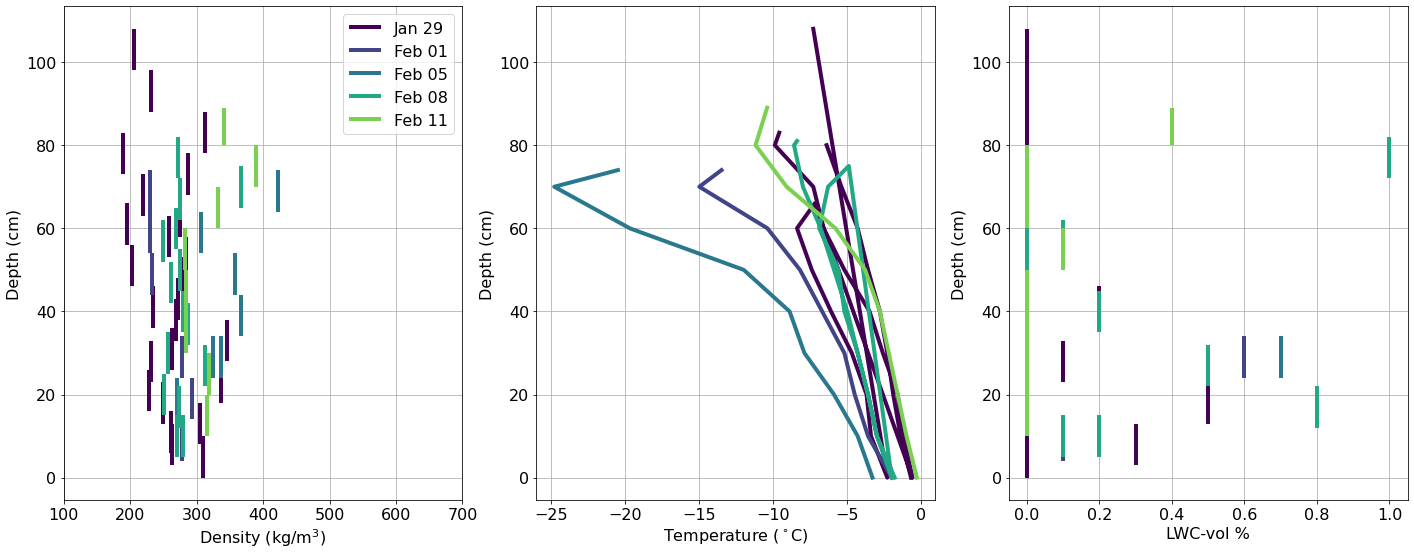

In [19]:
# plot depth vs. density colored by time 
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
plt.rcParams.update({'font.size': 16})

state = df_den['state'][0]
site = df_den['site'][0]

#  ====== density =========
grouped = df_den.groupby('date')
for i, (date, group) in enumerate(grouped):
    axs[0].vlines(group['Avg Density (kg/m3)'], group['# Top (cm)'], group['Bottom (cm)'], 
                  colors=plt.cm.viridis(i / len(grouped)), linewidth=4, label=date)
                
# Add labels and title
axs[0].set_xlabel('Density (kg/m$^3$)')
axs[0].set_ylabel('Depth (cm)')
# axs[0].set_xlim(0, 600)
axs[0].set_xlim(100, 700)
axs[0].grid(True)

# ====== temperature =========
grouped = df_temp.groupby('date')
for i, (date, group) in enumerate(grouped):
    axs[1].plot(group['Temperature (deg C)'], group['# Height (cm)'], marker='', 
                linestyle='-', linewidth=4, label=date, color=plt.cm.viridis(i / len(grouped)))

# Add labels and title
axs[1].set_xlabel('Temperature ($^\circ$C)')
axs[1].set_ylabel('Depth (cm)')
axs[1].grid(True)

#  ======= lwc  =========
grouped = df_lwc.groupby('date')
for i, (date, group) in enumerate(grouped):
    axs[2].vlines(group['Avg LWC %'], group['# Top (cm)'], group['Bottom (cm)'], 
                  colors=plt.cm.viridis(i / len(grouped)), linewidth=4)

# Add labels and title
axs[2].set_xlabel('LWC-vol %')
axs[2].set_ylabel('Depth (cm)')
axs[2].grid(True)

# Add legend to the first subplot and format legend labels
handles, labels = axs[0].get_legend_handles_labels()
legend = axs[0].legend(handles, labels, loc='upper right', bbox_to_anchor=(1., 1.)) # try 1.1, 1.2 for ones that need it! ("10% off the page)
for label in legend.get_texts():
    label.set_text(pd.to_datetime(label.get_text()).strftime('%b %d'))


plt.subplots_adjust(wspace=.5)
# plt.savefig(path_fig.joinpath(f'S20_den_temp_lwc_{state}-{site}.jpg'))
plt.savefig(path_out.joinpath(f'S20_den_temp_lwc_GM{state}-S1-8.jpg'))
plt.tight_layout()
plt.show()